In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

In [2]:
file_path = r"E:\Customer_segmentation\Online Retail.xlsx"
df = pd.read_excel(file_path)
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# drop missing customer ID
df = df.dropna(subset=['CustomerID'])

# Remove negative or zero quantities
df = df[df['Quantity'] > 0]

# Remove invalid or zero unitprices
df = df[df['UnitPrice'] > 0]

# Create a TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Confirm cleaning
print("Cleaned Dataset Shape:", df.shape)
df.head()

Cleaned Dataset Shape: (397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Define 'today' as one day after the last invoice date
today_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
# calculate RFM (Recency, Frequency, Monetary)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (today_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                 # Frequency
    'TotalPrice': 'sum'                                     # Monetary
}).reset_index()

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalPrice': 'Monetary'}, inplace=True)

print("RFM Table:")
rfm.head()

RFM Table:


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


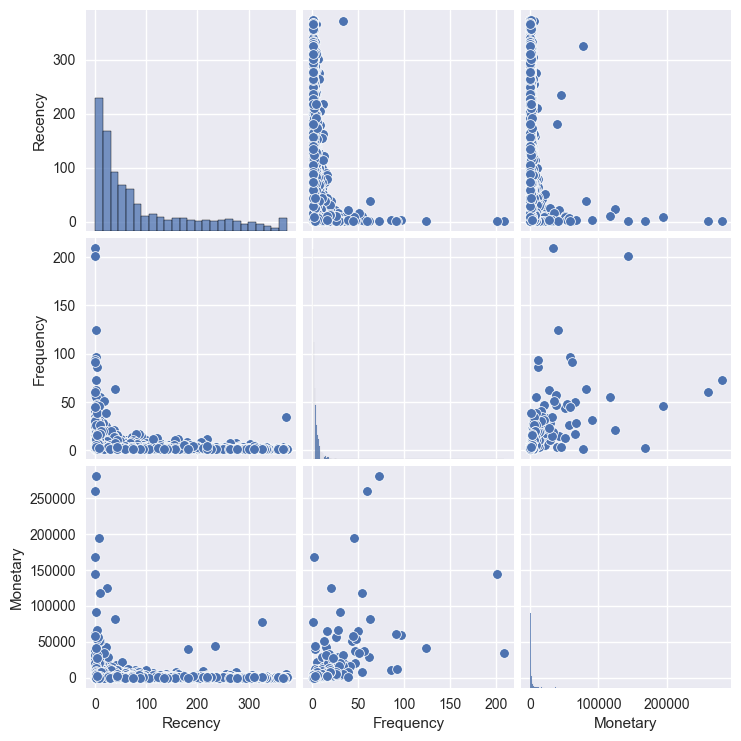

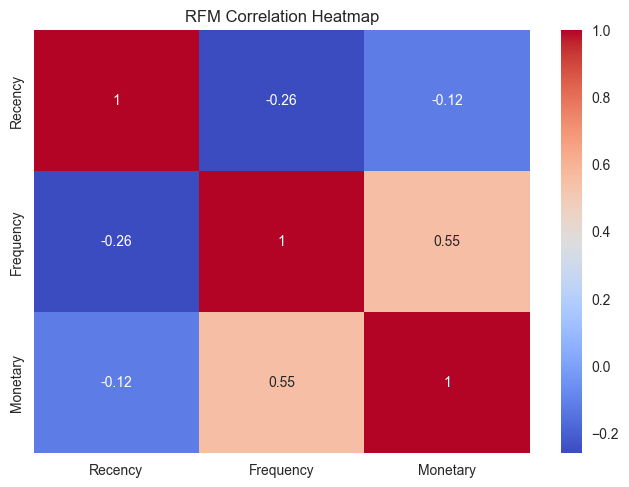

In [5]:
rfm.describe()

#visualize relations
sns.pairplot(rfm[['Recency', 'Frequency', 'Monetary']])
plt.show()
# Correlation heatmap
sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm')
plt.title("RFM Correlation Heatmap")
plt.show()


In [6]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

print("Scaled Data Shape:", rfm_scaled.shape)

Scaled Data Shape: (4338, 3)


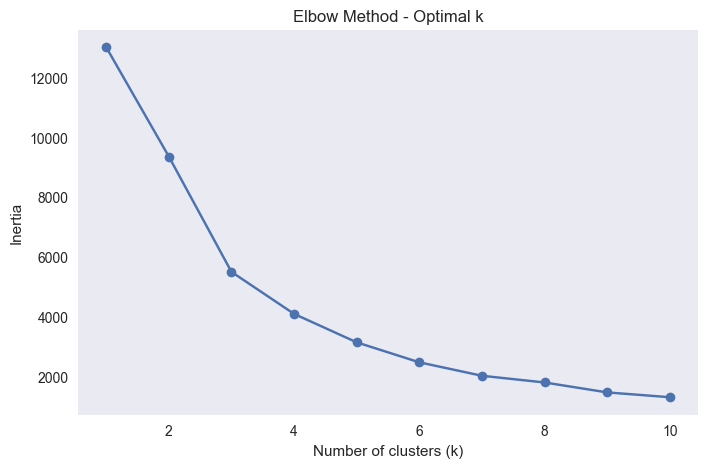

In [7]:
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method - Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()


In [8]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# summary
rfm.groupby('Cluster').mean().sort_values('Monetary', ascending=False)


,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
2,15435.000000,7.384615,82.538462,127338.313846
3,15212.857843,15.500000,22.333333,12709.090490
0,15289.128356,43.702685,3.682711,1359.049284
1,15347.791940,248.075914,1.552015,480.617480


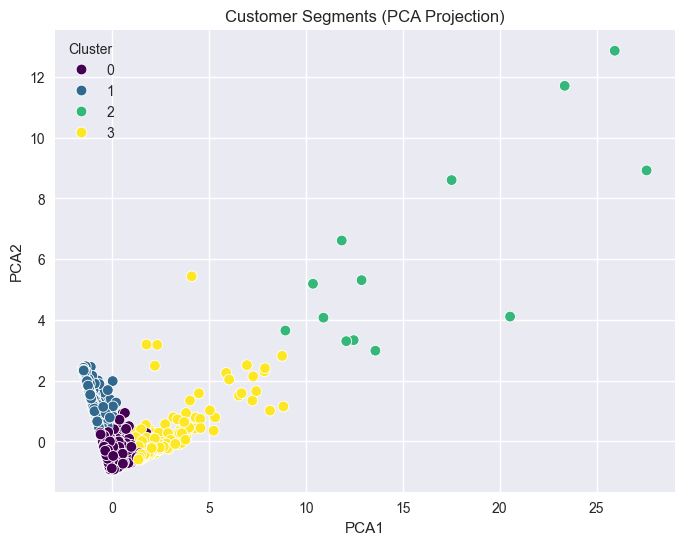

In [9]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm, palette='viridis', s=60)
plt.title("Customer Segments (PCA Projection)")
plt.show()


In [10]:
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).round(2)

cluster_profile

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,43.70,3.68,1359.05,3054
1,248.08,1.55,480.62,1067
2,7.38,82.54,127338.31,13
3,15.50,22.33,12709.09,204


In [11]:
# Interpretation guidelines
for c in cluster_profile.index:
    print(f"Cluster {c}:")
    if cluster_profile.loc[c, 'Monetary'] > rfm['Monetary'].median():
        print("High-value customers")
    elif cluster_profile.loc[c, 'Frequency'] < rfm['Frequency'].median():
        print("Low-frequency customers - need engagement")
    elif cluster_profile.loc[c, 'Recency'] > rfm['Recency'].median():
        print("Dormant customers")
    else:
        print(" Potential loyal customers")


Cluster 0:
High-value customers
Cluster 1:
Low-frequency customers - need engagement
Cluster 2:
High-value customers
Cluster 3:
High-value customers


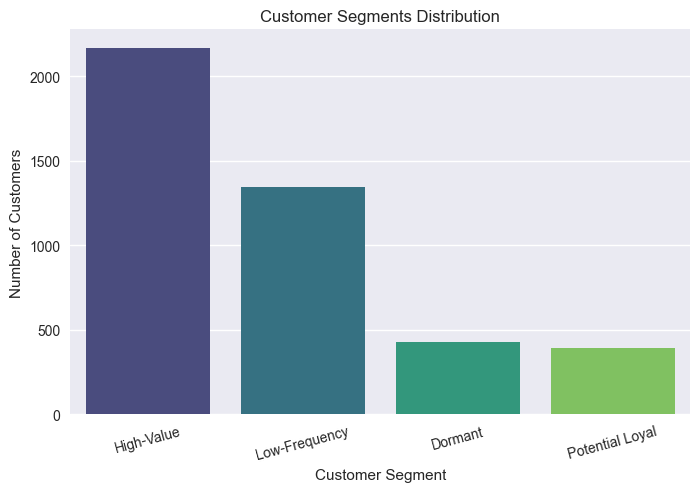

,Segment,Count
0,High-Value,2169
1,Low-Frequency,1347
2,Dormant,430
3,Potential Loyal,392


In [12]:
# Create a new column 'Segment'
def label_segment(row):
    if row['Monetary'] > rfm['Monetary'].median():
        return 'High-Value'
    elif row['Frequency'] < rfm['Frequency'].median():
        return 'Low-Frequency'
    elif row['Recency'] > rfm['Recency'].median():
        return 'Dormant'
    else:
        return 'Potential Loyal'
rfm['Segment'] = rfm.apply(label_segment, axis=1)

# Count customers in each segment
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

# Plot the results
plt.figure(figsize=(8,5))
sns.barplot(x='Segment', y='Count', data=segment_counts, palette='viridis')
plt.title("Customer Segments Distribution")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=15)
plt.show()

# Display counts in table format too
segment_counts


In [13]:

df_segmented = df.copy()


segment_map = rfm.set_index('CustomerID')['Segment'].to_dict()


df_segmented['Segment'] = df_segmented['CustomerID'].map(segment_map)


print("New dataset shape:", df_segmented.shape)
df_segmented.head()


New dataset shape: (397884, 10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,High-Value
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,High-Value
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,High-Value
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,High-Value
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,High-Value


In [14]:
output_path = r"E:\Customer_segmentation\Online_Retail_Segmented.csv"
df_segmented.to_csv(output_path, index=False, encoding='utf-8')

print(f"CSV file successfully saved at:\n{output_path}")


CSV file successfully saved at:
E:\Customer_segmentation\Online_Retail_Segmented.csv
